In [1]:
import sys
sys.path.insert(0, './main')
from regcoil import *
# Frank: avg_laplace_force seems to calculate the Lorentz force.
# avg=avg_laplace_force.Avg_laplace_force(cws)
# 
# def compute_L_eps(cws,coeff,eps):
#     ...
#     return avg.L_eps_optimized(coeff,eps)
# # But then this function wasn't used anywhere.
# laplace_array=avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)
# laplace_aux=compute_aux(cws,laplace_array)#[laplace_norm,laplace_normal,laplace_tangent,laplace_norm_tangent]
import avg_laplace_force
from tqdm import tqdm
from vector_field_on_TS import *
%matplotlib inline

In [2]:
from matplotlib import colors
plt.rcParams['figure.figsize'] = [15, 25]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
def plot_jupyter(fig, axs,lst_data,lst_title,suptitle,cmap="jet",vmin=None):
    fig.suptitle(suptitle)

    images = []
    for i in range(len(axs)):
        data = lst_data[i]
        images.append(axs[i].imshow(data, cmap=cmap, origin='lower'))
        axs[i].label_outer()
        axs[i].set_title(lst_title[i])
        axs[i].text(0,0,'max = {:.2E}'.format(np.max(data.flatten())))

    # Find the min and max of all colors for use in setting the color scale.
    if vmin is None:
        vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    #norm = colors.Normalize(vmin=vmin, vmax=vmax)
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    #fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)
    fig.colorbar(images[0], ax=axs,fraction=.1)

    # Make images respond to changes in the norm of other images (e.g. via the
    # "edit axis, curves and images parameters" GUI on Qt), but be careful not to
    # recurse infinitely!
    def update(changed_image):
        for im in images:
            if (changed_image.get_cmap() != im.get_cmap()
                    or changed_image.get_clim() != im.get_clim()):
                im.set_cmap(changed_image.get_cmap())
                im.set_clim(changed_image.get_clim())


    for im in images:
        im.callbacksSM.connect('changed', update)
def plot_bicolor(lst_title,lst_data,suptitle):
    fig, axs = plt.subplots(4, 2)
    fig.suptitle(suptitle)
    laxs=axs.flatten()
    im=[]
    x_label_list = ['$\pi/6$', '$\pi/3$', '$\pi/2$', '$2\pi/3$']
    y_label_list = ['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
    for i in range(3):
        im.append(laxs[i].imshow(lst_data[i], cmap='jet', origin='lower',extent=[0,1,0,1]))
        laxs[i].set_title(lst_title[i])
        laxs[i].set_xlabel("Toroidal angle")
        laxs[i].set_ylabel("poloidal angle")
        laxs[i].set_xticks([0.25,0.5,0.75,1])
        laxs[i].set_xticklabels(x_label_list)
        laxs[i].set_yticks([0.25,0.5,0.75,1])
        laxs[i].set_yticklabels(y_label_list)
    for i in range(3,7):
        im.append(laxs[i].imshow(lst_data[i], cmap='seismic', origin='lower',extent=[0,1,0,1]))
        laxs[i].set_title(lst_title[i])
        laxs[i].set_xlabel("Toroidal angle")
        laxs[i].set_ylabel("poloidal angle")
        laxs[i].set_xticks([0.25,0.5,0.75,1])
        laxs[i].set_xticklabels(x_label_list)
        laxs[i].set_yticks([0.25,0.5,0.75,1])
        laxs[i].set_yticklabels(y_label_list)
    vmin = im[3].get_array().min()
    vmax = im[3].get_array().max()
    #print(vmin)
    norm = colors.Normalize(vmin=vmin, vmax=-vmin)
    im[3].set_norm(norm)
    norm2 = colors.Normalize(vmin=0, vmax=np.pi)
    im[4].set_norm(norm2)
    for i in range(len(laxs)-1):
        fig.colorbar(im[i],ax=laxs[i],fraction=.1)
    plt.savefig("figure.png")
def plot_bicolor_compare(lst_title,lst_data,suptitle,split_number,angle=[]):
    #split_number is the number of positive plot
    fig, axs = plt.subplots(len(lst_title), 2)
    fig.suptitle(suptitle)
    laxs=axs.flatten()
    im=[]
    x_label_list = ['$\pi/6$', '$\pi/3$', '$\pi/2$', '$2\pi/3$']
    y_label_list = ['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
    for i in range(2*split_number):
        im.append(laxs[i].imshow(lst_data[i], cmap='jet', origin='lower',extent=[0,1,0,1]))
        laxs[i].set_title(lst_title[i//2])
        laxs[i].set_xlabel("Toroidal angle")
        laxs[i].set_ylabel("poloidal angle")
        laxs[i].set_xticks([0.25,0.5,0.75,1])
        laxs[i].set_xticklabels(x_label_list)
        laxs[i].set_yticks([0.25,0.5,0.75,1])
        laxs[i].set_yticklabels(y_label_list)
        laxs[i].text(0,0,'max = {:.2E}'.format(np.max(lst_data[i].flatten())))
        if i%2==1:
            vmin = min(image.get_array().min() for image in im[-2:])
            vmax = max(image.get_array().max() for image in im[-2:])
            norm = colors.LogNorm(vmin=vmin, vmax=vmax)
            im[-1].set_norm(norm)
            im[-2].set_norm(norm)
    for i in range(2*split_number,len(lst_data)):
        im.append(laxs[i].imshow(lst_data[i], cmap='seismic', origin='lower',extent=[0,1,0,1]))
        laxs[i].set_title(lst_title[i//2])
        laxs[i].set_xlabel("Toroidal angle")
        laxs[i].set_ylabel("poloidal angle")
        laxs[i].set_xticks([0.25,0.5,0.75,1])
        laxs[i].set_xticklabels(x_label_list)
        laxs[i].set_yticks([0.25,0.5,0.75,1])
        laxs[i].set_yticklabels(y_label_list)
        laxs[i].text(0,0,'max = {:.2E}'.format(np.max(np.abs(lst_data[i]).flatten())))
        if i%2==1:
            if i//2 not in angle:
                vmin = min(image.get_array().min() for image in im[-2:])
                vmax = max(image.get_array().max() for image in im[-2:])
                vv=max(-vmin,vmax)
                norm = colors.Normalize(vmin=-vv, vmax=vv)
            else :
                norm = colors.Normalize(vmin=0, vmax=np.pi)
            im[-1].set_norm(norm)
            im[-2].set_norm(norm)
    #vmin = im[3].get_array().min()
    #vmax = im[3].get_array().max()
    #print(vmin)
    #norm = colors.Normalize(vmin=vmin, vmax=-vmin)
    #im[3].set_norm(norm)
    #norm2 = colors.Normalize(vmin=0, vmax=np.pi)
    #im[4].set_norm(norm2)
    for i in range(len(lst_title)):
        fig.colorbar(im[2*i+1],ax=laxs[2*i:2*(i+1)],fraction=.1)
    plt.savefig("figure.png")

# Seem to calculate the components of laplace force
def compute_aux(cws,laplace_array,sel=1):
    laplace_norm=np.linalg.norm(laplace_array,axis=2)
    laplace_normal=np.sum(-1*cws.normal[:-1:sel,:-1:sel,:]*laplace_array,axis=2)
    laplace_tangent=laplace_array-laplace_normal[:,:,np.newaxis]*(-1*cws.normal[:-1:sel,:-1:sel,:])
    laplace_norm_tangent=np.linalg.norm(laplace_tangent,axis=2)
    return [laplace_norm,laplace_normal,laplace_tangent,laplace_norm_tangent]
def compute_L_eps(cws,coeff,eps):
    import importlib
    importlib.reload(avg_laplace_force)
    avg=avg_laplace_force.Avg_laplace_force(cws)
    return avg.L_eps_optimized(coeff,eps)


In [3]:
Np=3
ntheta_plasma = 64+1
ntheta_coil   = 64+1
nzeta_plasma = 64+1
nzeta_coil   = 64+1
mpol_coil  = 12 #probably not enough
ntor_coil  = 12 #probably not enough
net_poloidal_current_Amperes = 11884578.094260072/Np
net_toroidal_current_Amperes = 0.
curpol=4.9782004309255496
lamb1=1.2e-14
lamb2=2.5e-16
lamb3=5.1e-19
lamb=lamb3
gamma=lamb2

In [4]:
def cost(coeff_l):
    #to check compatibility
    sol_C,sol_S=vector_field_on_TS.Div_free_vector_field_on_TS.array_coeff_to_CS(coeff_l,phisize)
    b_array=get_bnorm(path_bnorm,plasma_surf)
    b_vec=-curpol*(b_array[:-1,:-1]).flatten()
    err_B=(div_free.compute_normal_B(plasma_surf,(G,I,sol_C,sol_S))-b_vec)
    surf_err=np.mean(err_B*err_B*plasma_surf.dS[:-1,:-1].flatten())*plasma_surf.Np
    j=vector_field_on_TS.get_full_j(sol_C,sol_S,div_free.surf.dpsidu,div_free.surf.dpsidv,div_free.surf.dS,div_free.surf.grid,G,I)
    norm_j=np.linalg.norm(j,axis=2)[:-1,:-1]
    err_j=np.mean(norm_j*norm_j*div_free.surf.dS[:-1,:-1])*cws.Np
    coeff=(G,I,sol_C,sol_S)
    laplace_array=avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)
    error2=np.linalg.norm(laplace_array,axis=2)**2
    avg_Laplace=np.sum(error2*cws.dS[:-1,:-1])/((cws.lu-1)*(cws.lv-1))*cws.Np
    err_tot=surf_err+lamb*err_j+gamma*avg_Laplace
    print('cost : surface error = {:.5E} ,\n j norm = {:.5E} \n Laplace norm = {:.5E}\n total cost = {:.5E}'.format(surf_err,err_j,avg_Laplace,err_tot))
    return (np.reshape(err_B,(plasma_surf.lu-1,plasma_surf.lv-1)))

In [5]:
phisize=(ntor_coil,mpol_coil)
G,I=net_poloidal_current_Amperes,net_toroidal_current_Amperes
path_plasma='li383/plasma_surf.txt'
path_cws='li383/cws.txt'
path_bnorm='li383/bnorm.txt'
plasma_surf=toroidal_surface.Toroidal_surface(W7x_pathfile=path_plasma,nbpts=(ntheta_plasma,nzeta_plasma),Np=3)
cws=toroidal_surface.Toroidal_surface(W7x_pathfile=path_cws,nbpts=(ntheta_coil,nzeta_coil),Np=3)
div_free=vector_field_on_TS.Div_free_vector_field_on_TS(cws)
avg=avg_laplace_force.Avg_laplace_force(cws)

In [6]:
sol1,div_free=Regcoil(G,I,lamb1,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)
sol2,div_free=Regcoil(G,I,lamb2,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)
sol3,div_free=Regcoil(G,I,lamb3,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)
#cost(sol3)

opening cache/reg
optimization successfull,
 surface error = 1.36264E-01 ,
 avg surface j norm = 1.00000E+14
erreur max : 2.67319E-01, jmax : 3.79907E+06
optimization successfull,
 surface error = 4.80196E-03 ,
 avg surface j norm = 1.43285E+14
erreur max : 5.15245E-02, jmax : 7.42079E+06
optimization successfull,
 surface error = 1.44123E-04 ,
 avg surface j norm = 4.90577E+14
erreur max : 1.51094E-02, jmax : 2.16527E+07


In [7]:
sol4,div_free=Regcoil(G,I,0,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)

optimization successfull,
 surface error = 2.24601E-05 ,
 avg surface j norm = 1.63881E+19
erreur max : 4.13204E-03, jmax : 6.80387E+09


In [8]:
lst_data_sol=[]
lst_sol=[sol1,sol2,sol3]
for i in range(len(lst_sol)):
    sol_C,sol_S=vector_field_on_TS.Div_free_vector_field_on_TS.array_coeff_to_CS(lst_sol[i],phisize)
    b_array=get_bnorm(path_bnorm,plasma_surf)
    b_vec=-curpol*(b_array[:-1,:-1]).flatten()
    err_B=(div_free.compute_normal_B(plasma_surf,(G,I,sol_C,sol_S))-b_vec)
    surf_err=np.mean(err_B*err_B*plasma_surf.dS[:-1,:-1].flatten())
    j=vector_field_on_TS.get_full_j(sol_C,sol_S,div_free.surf.dpsidu,div_free.surf.dpsidv,div_free.surf.dS,div_free.surf.grid,G,I)
    norm_j=np.linalg.norm(j,axis=2)[:-1,:-1]
    err_j=np.mean(norm_j*norm_j*div_free.surf.dS[:-1,:-1])
    
    print('avg surface error = {:.5E}[T^2.m^2] ,\n avg surface j norm = {:.5E}A^2/m^2'.format(surf_err*plasma_surf.Np,err_j*cws.Np))
    lst_data_sol.append(norm_j)
    lst_data_sol.append(np.reshape(err_B,(plasma_surf.lu-1,plasma_surf.lv-1)))

avg surface error = 1.36264E-01[T^2.m^2] ,
 avg surface j norm = 1.00000E+14A^2/m^2
avg surface error = 4.80196E-03[T^2.m^2] ,
 avg surface j norm = 1.43285E+14A^2/m^2
avg surface error = 1.44123E-04[T^2.m^2] ,
 avg surface j norm = 4.90577E+14A^2/m^2


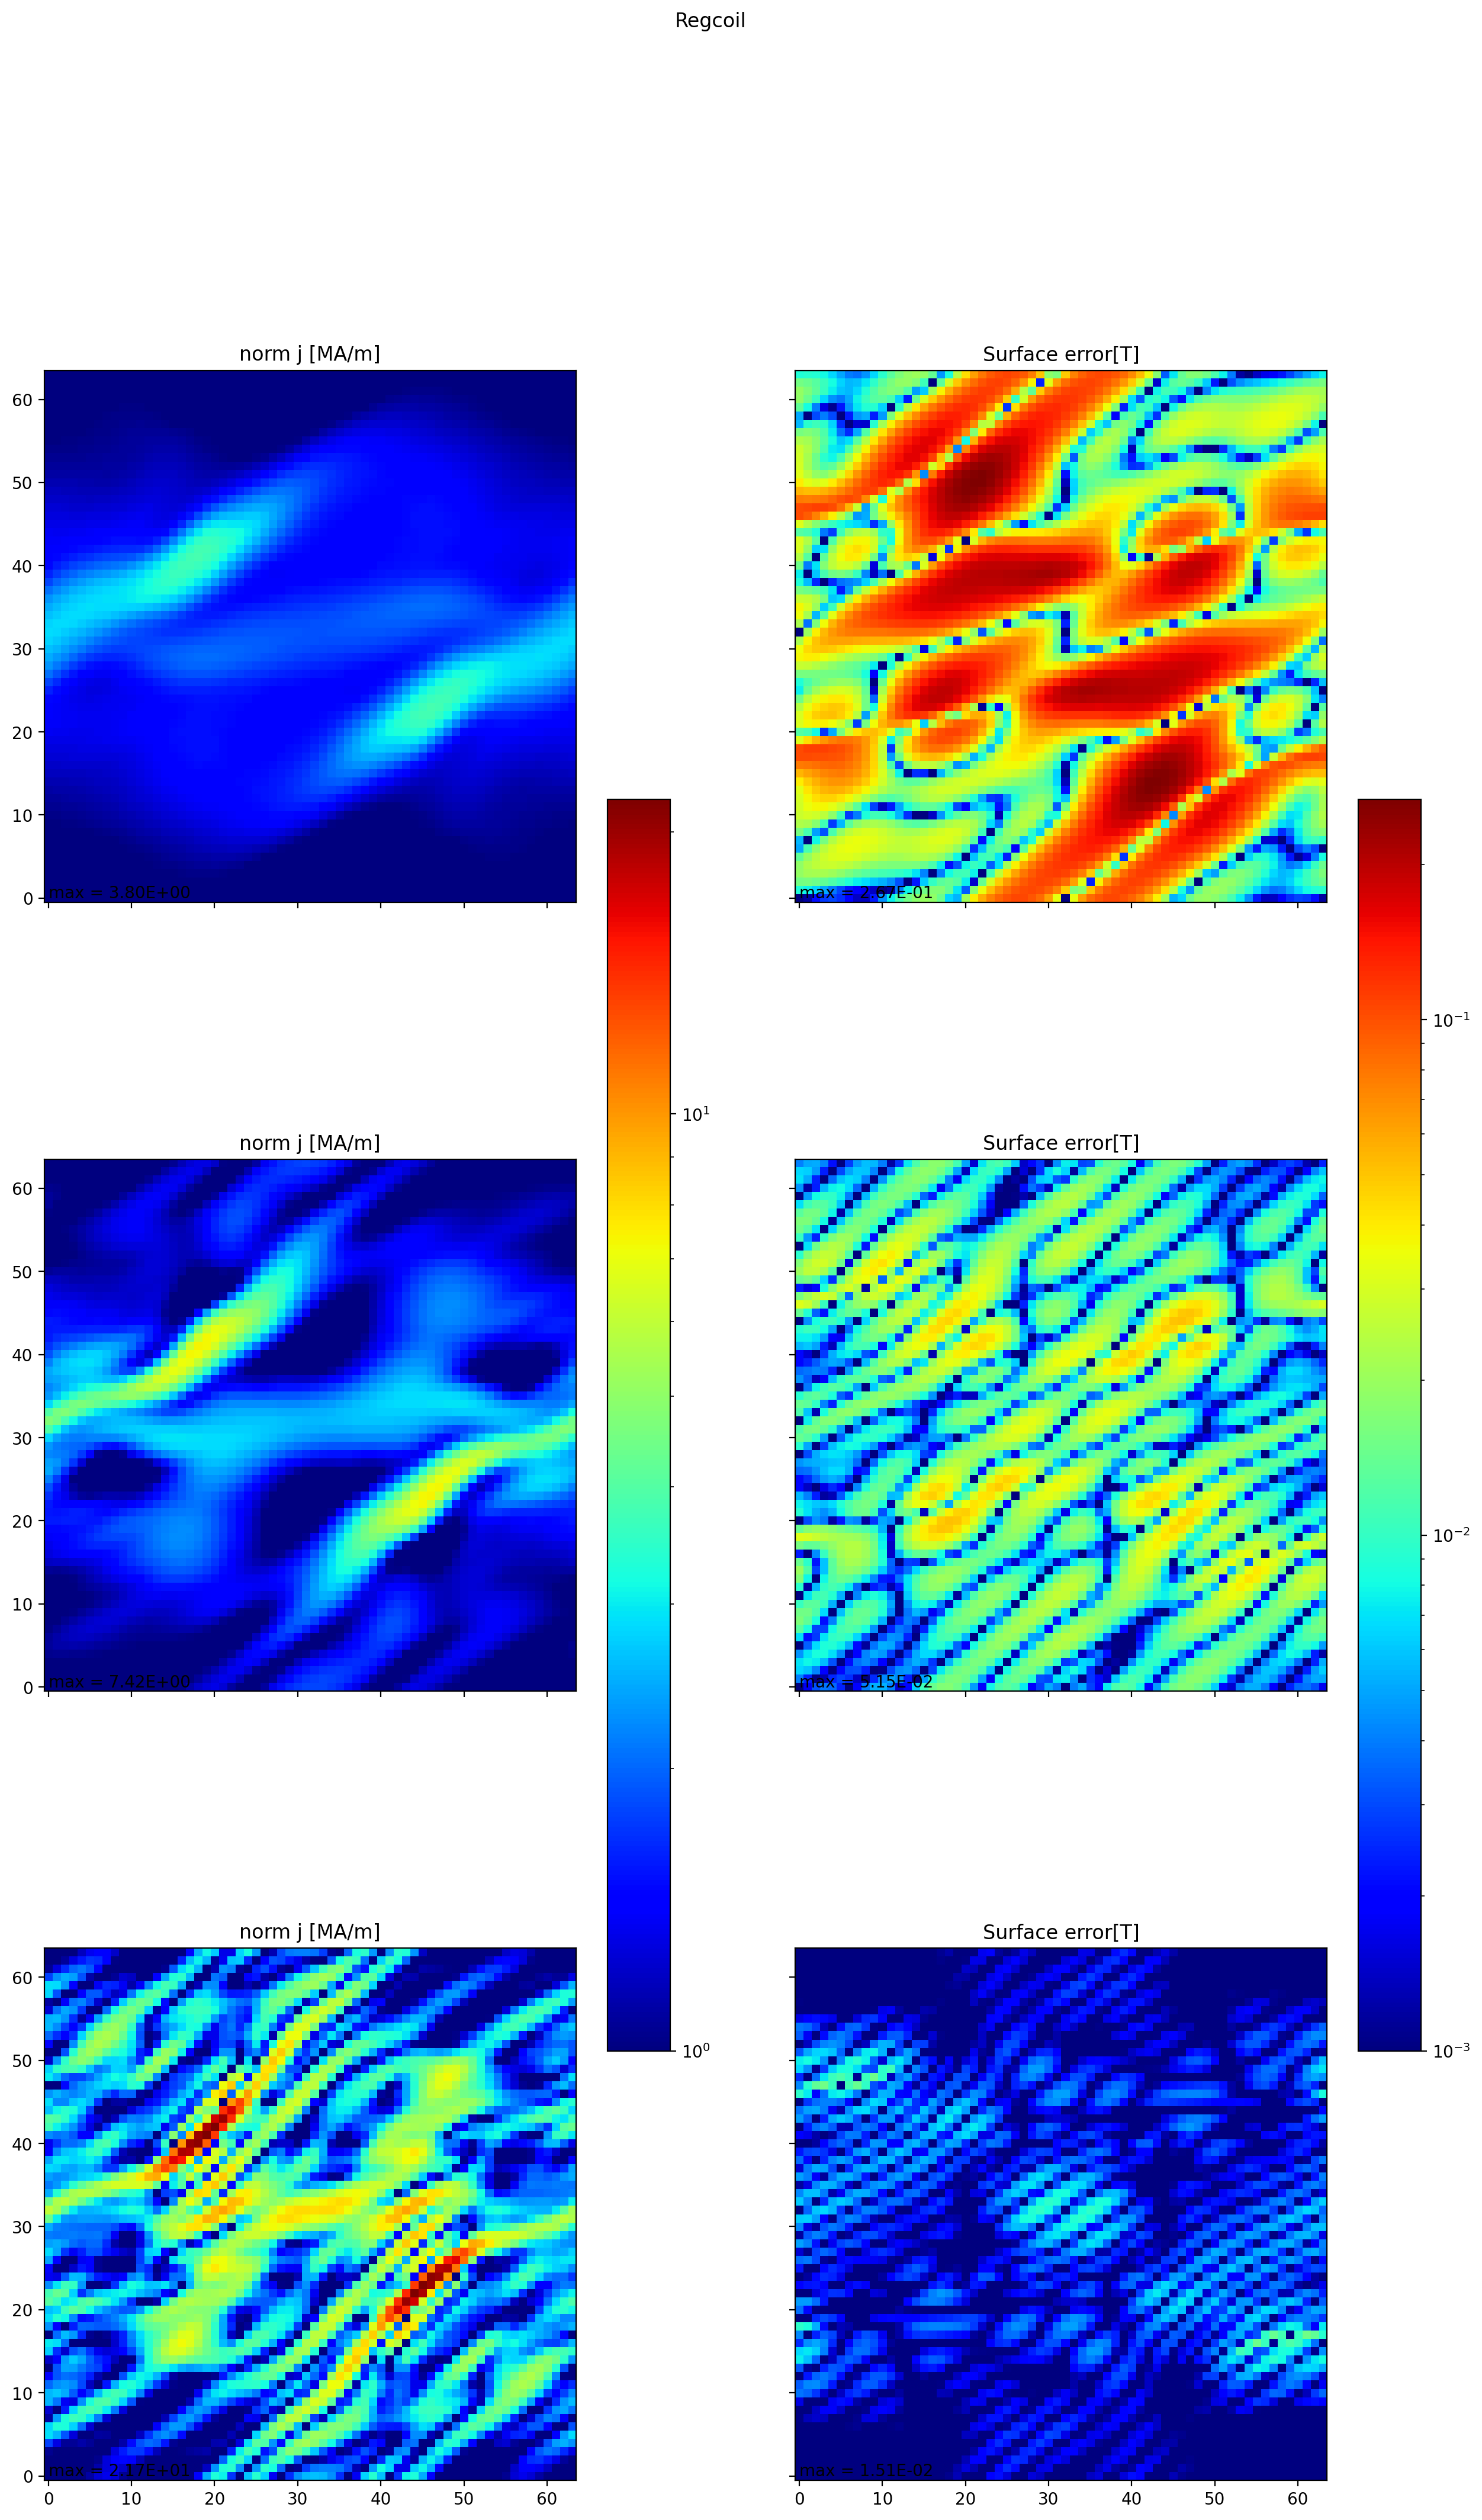

In [9]:
lst_title=['norm j [MA/m]','Surface error[T]']*3
Nr = 3
Nc = 2
cmap = "jet"
suptitle='Regcoil'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs[:,0],np.array(lst_data_sol[0::2])/1e6,lst_title[::2],suptitle,cmap,vmin=1)
plot_jupyter(fig,axs[:,1],np.abs(lst_data_sol[1::2]),lst_title[1::2],suptitle,cmap,vmin=1e-3)

In [10]:
eps=1e-2
lst_theta=range(ntheta_coil-1)
lst_zeta=range(nzeta_coil-1)
Pm=(np.array([cws.X,cws.Y,cws.Z])+eps*cws.n)[:,:-1,:-1].reshape((3,-1)).transpose()#inside
Pp=(np.array([cws.X,cws.Y,cws.Z])-eps*cws.n)[:,:-1,:-1].reshape((3,-1)).transpose()

In [11]:
def compute_value_to_plot_compare(coeff_l):
    import importlib
    importlib.reload(avg_laplace_force)
    avg=avg_laplace_force.Avg_laplace_force(cws)
    sol_C,sol_S=vector_field_on_TS.Div_free_vector_field_on_TS.array_coeff_to_CS(coeff_l,phisize)
    coeff=(G,I,sol_C,sol_S)
    laplace_array=avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)
    laplace_aux=compute_aux(cws,laplace_array)#[laplace_norm,laplace_normal,laplace_tangent,laplace_norm_tangent]
    Bm=div_free.compute_B(np.array(Pm),coeff)
    Bp=div_free.compute_B(np.array(Pp),coeff)
    j1=div_free.get_full_j(coeff)
    L_eps=np.zeros((len(lst_theta),len(lst_zeta),3))
    B_eps=np.zeros((len(lst_theta),len(lst_zeta),3))
    flag=0
    for theta in lst_theta:
        for zeta in lst_zeta:
            L_eps[flag//len(lst_zeta),flag%len(lst_zeta),:]=0.5*(np.cross(j1[theta,zeta,:],Bm[:,flag]+Bp[:,flag]))
            B_eps[flag//len(lst_zeta),flag%len(lst_zeta),:]=0.5*(Bm[:,flag]+Bp[:,flag])
            flag+=1
    L_eps_norm=np.linalg.norm(L_eps,axis=2)
    B_eps_norm=np.linalg.norm(B_eps,axis=2)
    j_norm=np.linalg.norm(j1[:-1,:-1,:],axis=2)
    j_scalar_B=np.sum(B_eps*j1[:-1,:-1,:],axis=2)
    acos=np.arccos(j_scalar_B/(B_eps_norm*j_norm))
    B_eps_normal=np.sum(-1*cws.normal[:-1,:-1,:]*B_eps,axis=2)
    return (laplace_aux,B_eps_norm,j_norm,j_scalar_B,acos,B_eps_normal)

In [12]:
(laplace_aux,B_eps_norm,j_norm,j_scalar_B,acos,B_eps_normal)=compute_value_to_plot_compare(sol2)

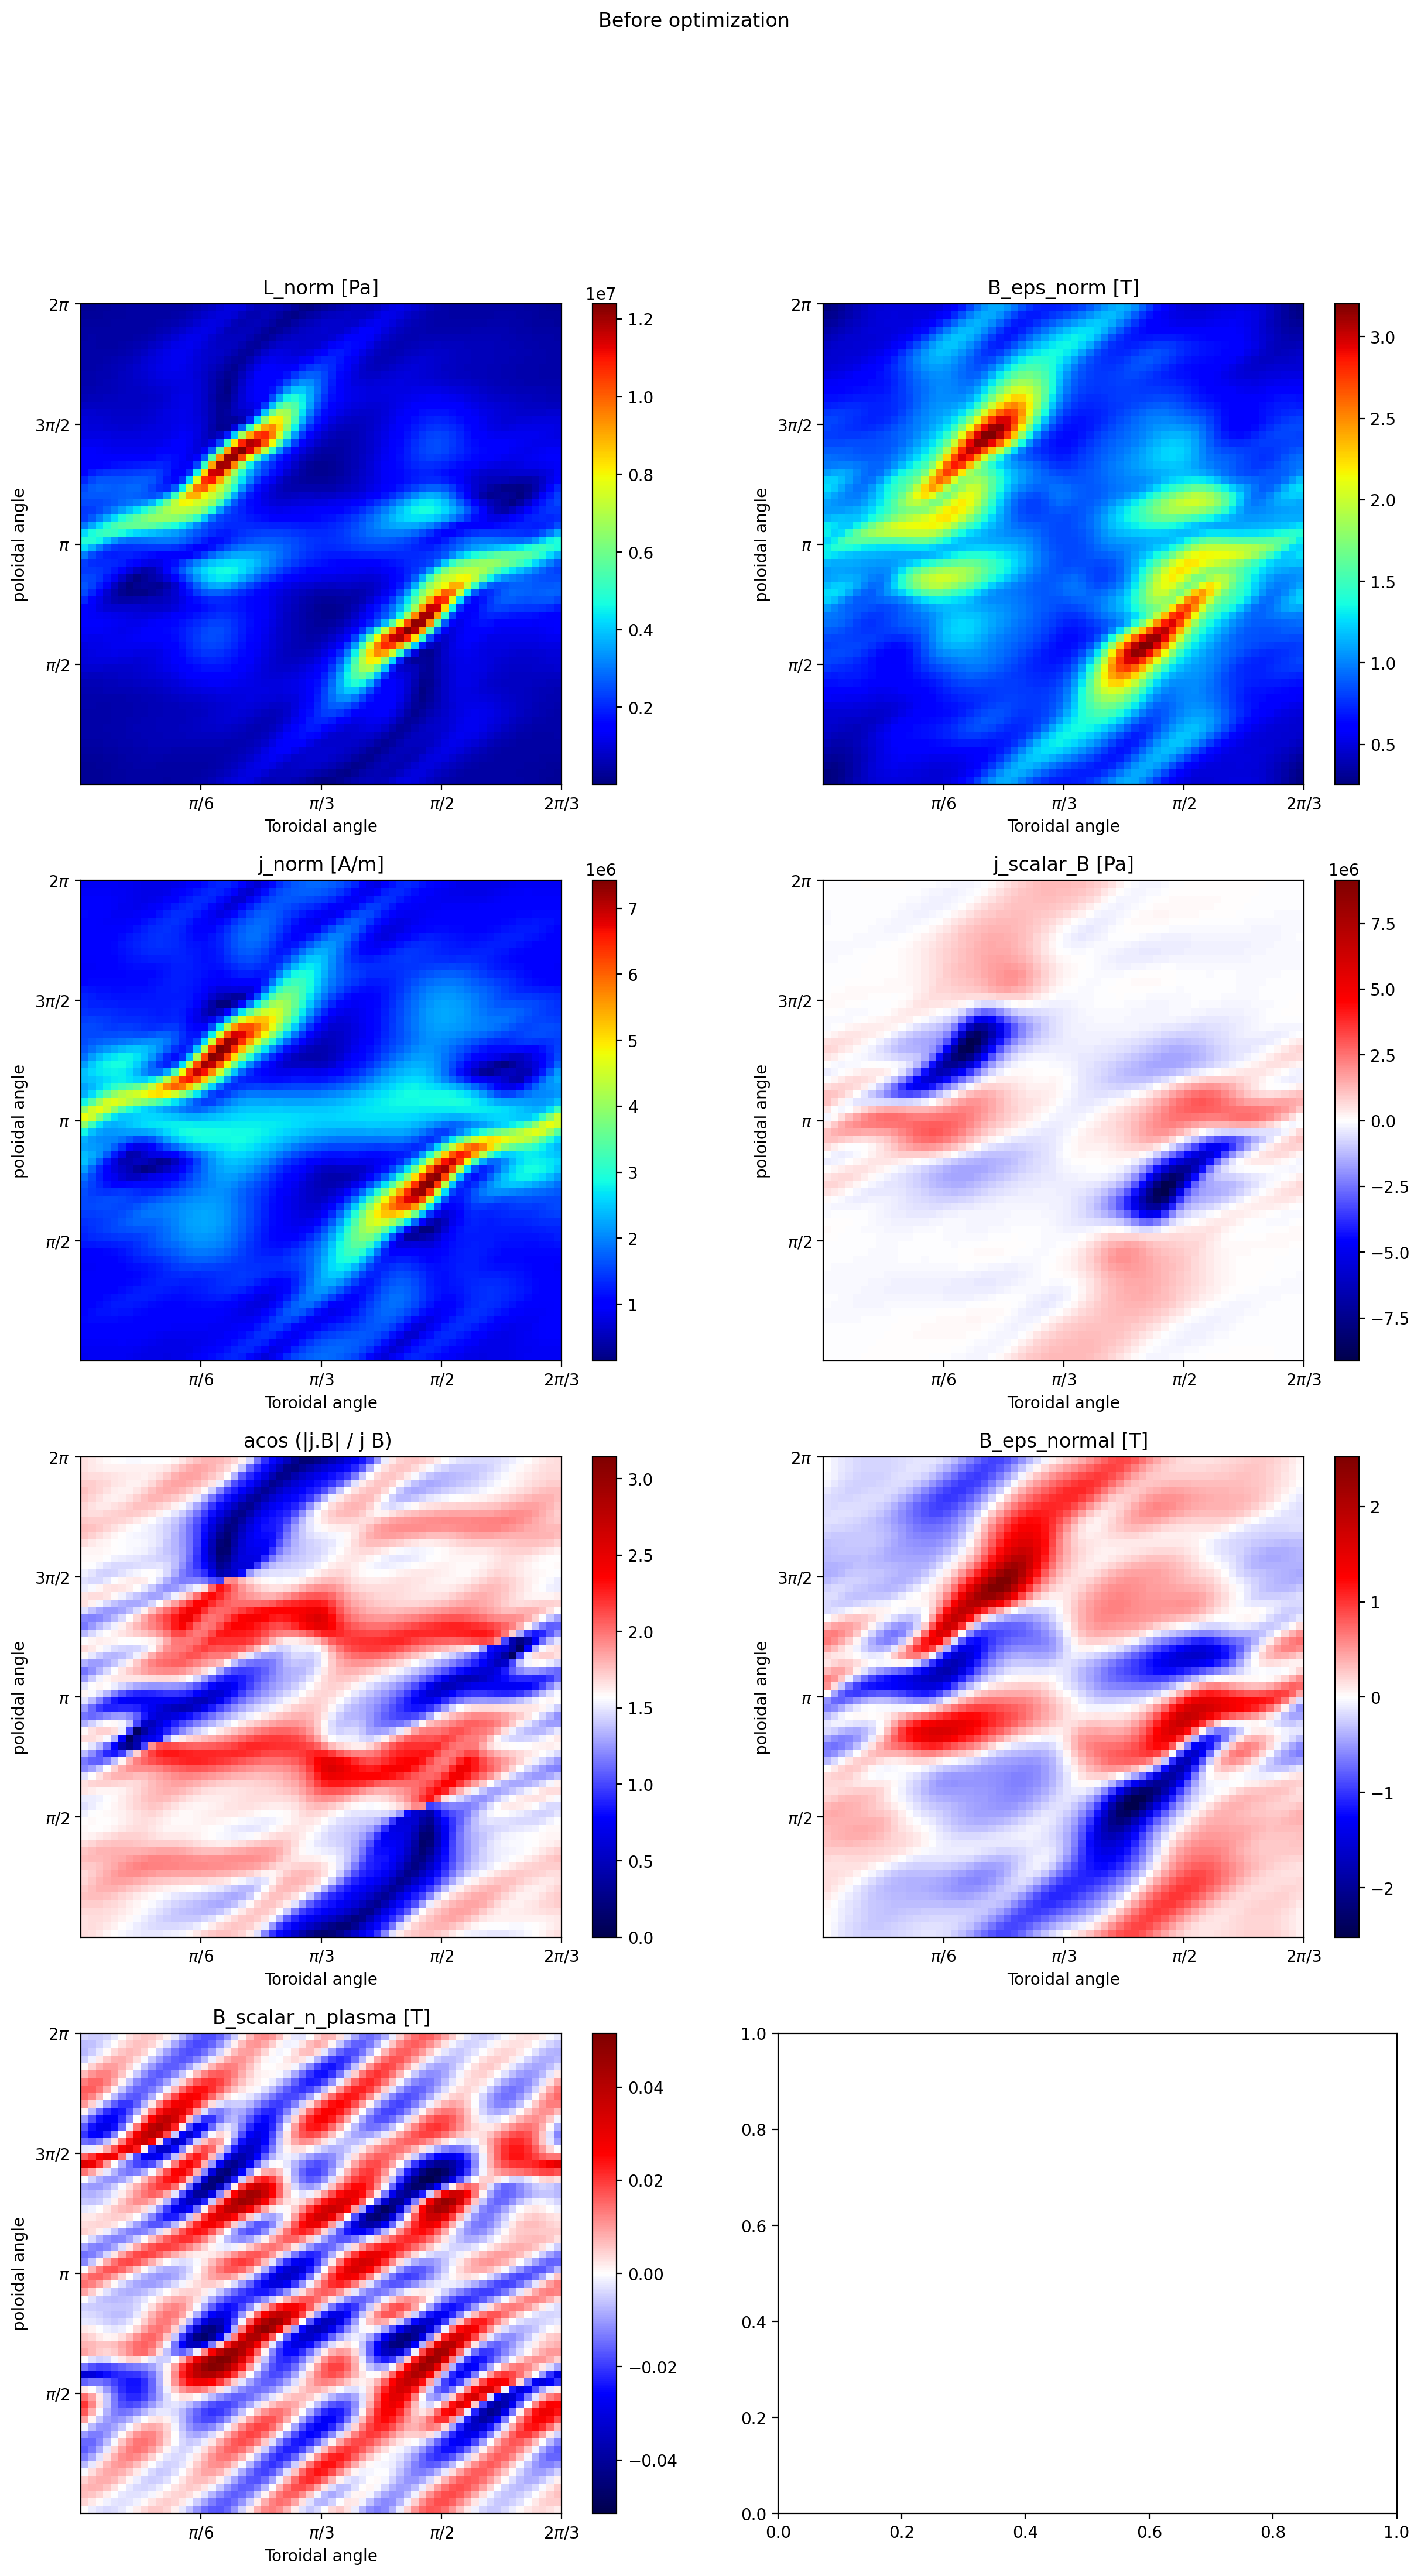

In [13]:
#plt.rcParams["text.usetex"]=False
lst_title=['L_norm [Pa]','B_eps_norm [T]','j_norm [A/m]','j_scalar_B [Pa]','acos (|j.B| / j B) ','B_eps_normal [T]','B_scalar_n_plasma [T]']
lst_data=[laplace_aux[0],B_eps_norm,j_norm,j_scalar_B,acos,B_eps_normal,lst_data_sol[3]]
suptitle='Before optimization'
#plot_bicolor(lst_title,lst_data,suptitle)
#suptitle='Laplace forces'
#lst_data=np.abs(np.array([laplace_norm,laplace_normal,laplace_norm_tangent,laplace_array[:,:,0],laplace_array[:,:,1],laplace_array[:,:,2],lst_data_sol[2]]))

In [14]:
import pickle
#f=open("../coeff_full_opt",'rb')
f=open("../coeff_full_opt_from_tensor",'rb')
res=pickle.load(f)
f.close()
#print(res)
coeff_l_opt=res.x
#res

In [15]:
err_B=cost(coeff_l_opt)
cost(sol2)
(laplace_aux_2,B_eps_norm_2,j_norm_2,j_scalar_B_2,acos_2,B_eps_normal_2)=compute_value_to_plot_compare(coeff_l_opt)

cost : surface error = 6.35774E-03 ,
 j norm = 1.41472E+14 
 Laplace norm = 1.51803E+14
 total cost = 4.43807E-02
cost : surface error = 4.80196E-03 ,
 j norm = 1.43285E+14 
 Laplace norm = 1.68697E+14
 total cost = 4.70492E-02


In [16]:
#plt.rcParams["text.usetex"]=False
lst_title=['L_norm [Pa]','B_eps_norm [T]','j_norm [A/m]','j_scalar_B [Pa]','acos (|j.B| / j B) ','B_eps_normal [T]','B_scalar_n_plasma [T]']
lst_data=[laplace_aux_2[0],B_eps_norm_2,j_norm_2,j_scalar_B_2,acos_2,B_eps_normal_2,err_B]
suptitle='After optimization'
#plot_bicolor(lst_title,lst_data,suptitle)
#suptitle='Laplace forces'
#lst_data=np.abs(np.array([laplace_norm,laplace_normal,laplace_norm_tangent,laplace_array[:,:,0],laplace_array[:,:,1],laplace_array[:,:,2],lst_data_sol[2]]))

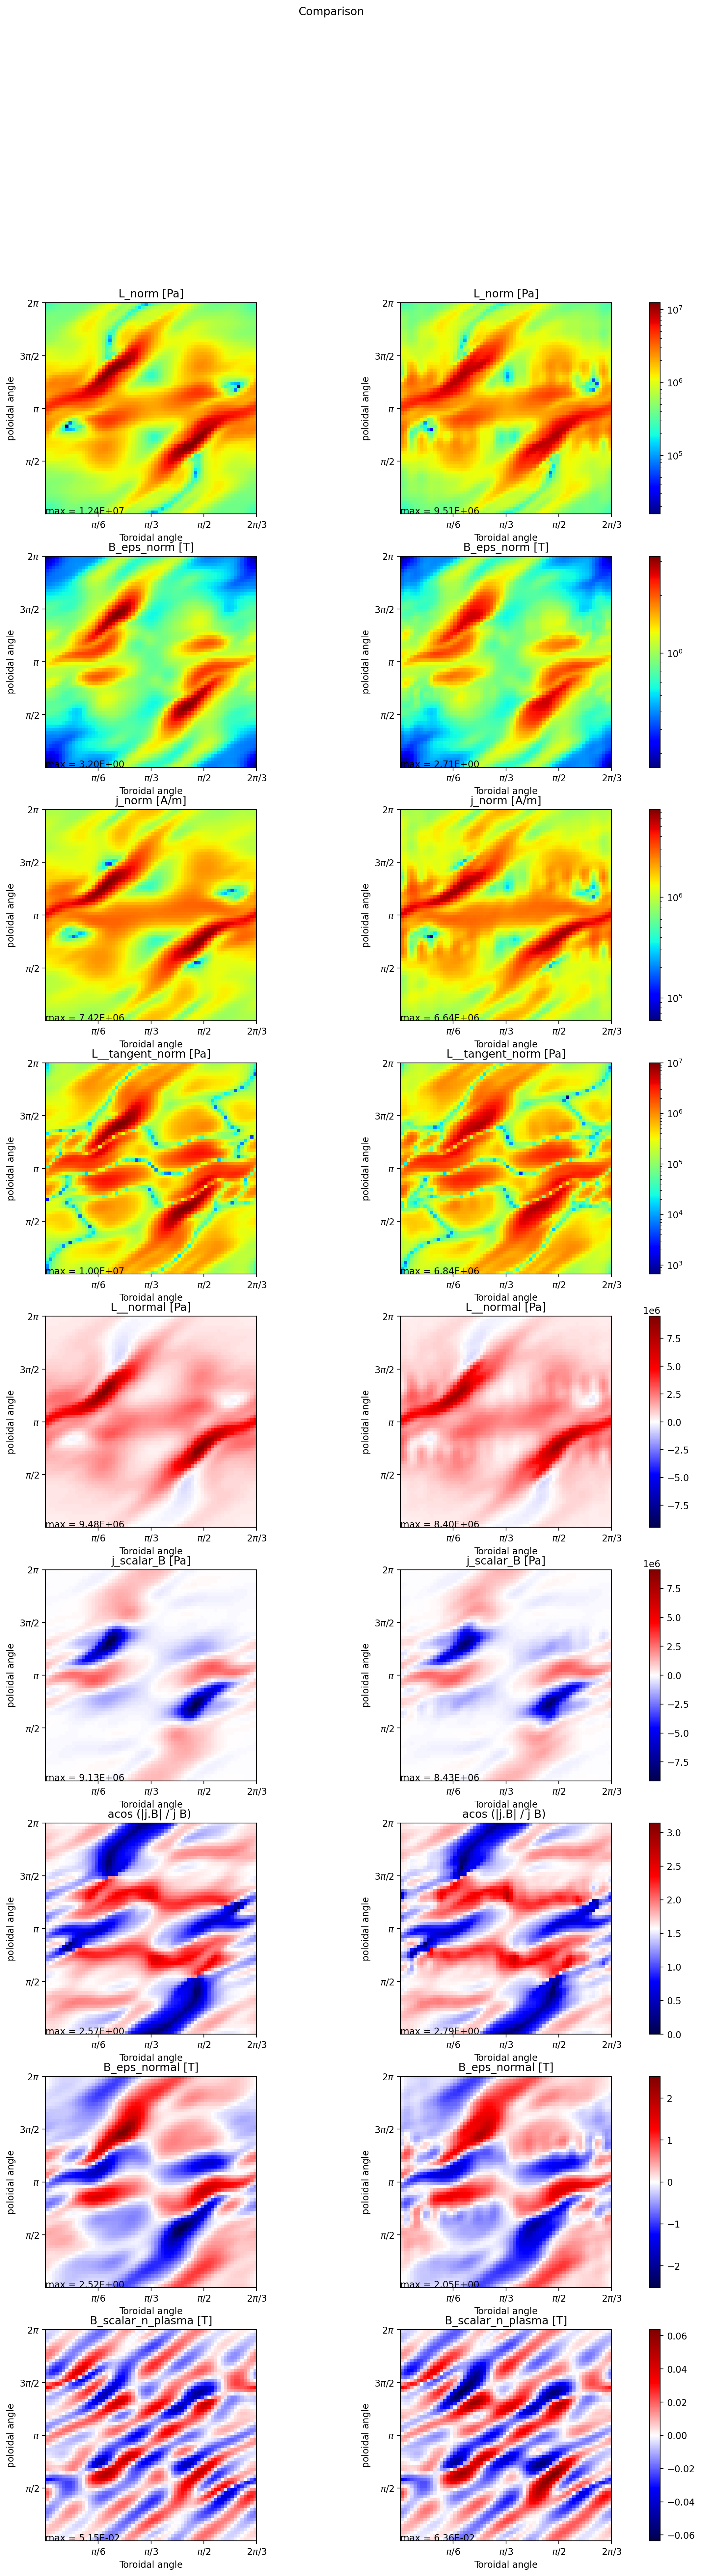

In [17]:
plt.rcParams['figure.figsize'] = [15, 45]
lst_title=['L_norm [Pa]','B_eps_norm [T]','j_norm [A/m]','L__tangent_norm [Pa]','L__normal [Pa]','j_scalar_B [Pa]','acos (|j.B| / j B) ','B_eps_normal [T]','B_scalar_n_plasma [T]']
lst_data=[laplace_aux[0],laplace_aux_2[0],B_eps_norm,B_eps_norm_2,j_norm,j_norm_2,laplace_aux[3],laplace_aux_2[3],laplace_aux[1],laplace_aux_2[1],j_scalar_B,j_scalar_B_2,acos,acos_2,B_eps_normal,B_eps_normal_2,lst_data_sol[3],err_B]
suptitle='Comparison'
plot_bicolor_compare(lst_title,lst_data,suptitle,4,angle=[6])